True

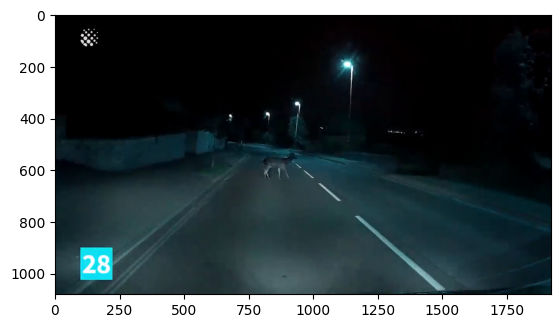

In [7]:
import cv2
import os
import pylab

cap = cv2.VideoCapture(f"COOOL Benchmark/video_0019.mp4")
ret, frame = cap.read()
cv2.imwrite("frame_demo_safe.png", frame)
for i in range(150):
    ret, frame = cap.read()
pylab.imshow(frame)
cv2.imwrite("frame_demo_danger.png", frame)

In [57]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 

model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)


image = Image.open("frame_demo.png")
# Check for cats and remote controls
# VERY important: text queries need to be lowercased + end with a dot
text = "dangerous obstacles"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.05,
    text_threshold=0,
    target_sizes=[image.size[::-1]]
)

['dangerous obstacles [SEP]', 'dangerous obstacles [SEP]', 'dangerous obstacles [SEP]', 'dangerous obstacles [SEP]', 'dangerous obstacles [SEP]', 'dangerous obstacles [SEP]']


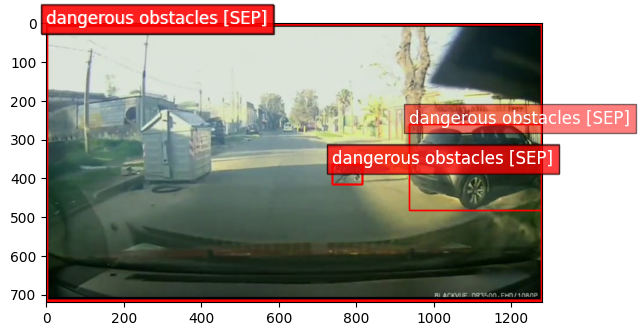

In [58]:
boxes = results[0]["boxes"].detach().cpu().numpy()
labels = results[0]["labels"]
print(labels)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(image)
 
for box in boxes:
    x, y, w, h = box
    rect = patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    label = labels[boxes.tolist().index(box.tolist())]
    plt.text(x, y, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    ax.add_patch(rect)

plt.show()

In [77]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image = Image.open("frame_demo_safe.png")

inputs = processor(text=["obstacles or hazards on the road; road with potential danger; objects that are not cars on the road; roads with trees; roads with people; roads with animals",
                         "clear and safe road; road without danger; road ready for driving; smooth road; roads with normal cars driving; road with cars on the side parked"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)
probs


tensor([[0.8780, 0.1220]], grad_fn=<SoftmaxBackward0>)

In [33]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-so400m-patch16-256-i18n")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch16-256-i18n")


prompts = {
    "safe": [
        "clear and safe road", "road without danger", "road ready for driving", "smooth road", "roads with normal cars driving", "road with cars on the side parked", "cracked road", "road with no cars", "road with no obstacles", "road with no people", "road with no animals", "road with no trees", "road with no boxes"
    ],
    "danger": [
        "obstacles or hazards on the road", "road with potential danger", "objects that are not cars on the road", "roads with human or people", "roads with animals", "road with boxes"
    ]
}
def run_frame(image):
    texts = prompts["safe"] + prompts["danger"]
    inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    logits_per_image = outputs.logits_per_image
    probs = torch.softmax(logits_per_image, dim=-1)
    return probs

import cv2
import os
import pylab
from tqdm import tqdm

cap = cv2.VideoCapture(f"COOOL Benchmark/video_0108.mp4")
ret, frame = cap.read()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('out.mp4', fourcc, 20.0, (frame.shape[1], frame.shape[0]))

frame_count = 0
bar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
while cap.isOpened():
    ret, frame = cap.read()
    bar.update(1)
    if not ret:
        break
    if frame_count % 4 == 0:
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        probs = run_frame(image)
        if torch.argmax(probs[0]) >= len(prompts["safe"]):
            cv2.putText(frame, 'Danger', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        out.write(frame)
    frame_count += 1

cap.release()
out.release()

 99%|█████████▉| 554/557 [01:50<00:00,  4.87it/s]